**Class Weight**: One initial option for dealing with class imbalance problems is to weight the two classes. By default the class weights for logistic regression in scikit-learn is `None`, meaning that both classes will be given equal importance in tuning the model. Alternatively, you can pass `'balanced'` in order to assign weights that are inversely proportional to that class's frequency. The final option is to explicitly pass weights to each class using a dictionary of the form `{'class_label': weight}`

To investigate this, we'll load a dataset on **Mobile App Downloads**. The data represents information regarding users of a website and whether or not they downloaded the app to their phone. As you can guess, most visitors don't download the app making it an imbalanced dataset as we had been discussing.

## Mobile Apps Distribution Dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv('mobile_app_attribution.csv')

# Data preview
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


Let's look at the level of class imbalance in the dataset:

In [2]:
print('Raw counts: \n')
print(df['is_attributed'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['is_attributed'].value_counts(normalize=True))

Raw counts: 

is_attributed
0    99773
1      227
Name: count, dtype: int64
-----------------------------------
Normalized counts: 

is_attributed
0    0.99773
1    0.00227
Name: proportion, dtype: float64


As you can see, over 99% of the data is the negative case. 

Then we'll define `X` and `y`: 

In [3]:
# Define appropriate X and y
y = df['is_attributed']
X = df[['ip', 'app', 'device', 'os', 'channel']]
X = pd.get_dummies(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

With that, let's compare a few models with varying class weights. 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Oversampling and undersampling**: Another technique that can be used is oversampling or undersampling. This can help address class imbalance problems when one category is far more prevalent than the other. This is a common case that occurs in medicine, image classification or fraud detection. In many of these scenarios, class imbalance can cause difficulties for the learning algorithm. After all, simply predicting the majority class could yield 99%+ accuracy if the rare class occurs <1% of the time. Due to this, sampling techniques such as **oversampling the minority class** or **undersampling the majority class** can help by producing a synthetic dataset that the learning algorithm is trained on. With this, it is important to still maintain a test set from the original dataset in order to accurately judge the accuracy of the algorithm overall.

Undersampling can only be used when you have a truly massive dataset and can afford to lose data points. However, even with very large datasets, you are losing potentially useful data. Oversampling can run into the issue of overfitting to certain characteristics of certain data points because there will be exact replicas of data points.

While these initial modifications will improve the performance of classification algorithms on imbalanced datasets, a more advanced technique known as SMOTE has produced even better results in practice.


**SMOTE** stands for **Synthetic Minority Oversampling**. Here, rather then simply oversampling the minority class with replacement (which simply adds duplicate cases to the dataset), the algorithm generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases. You can read more about SMOTE [here](https://jair.org/index.php/jair/article/view/10302/24590). 

SMOTE is generally a powerful way to deal with class imbalances, but it runs into computational issues when you have a large number of features due to the curse of dimensionality.
   
Implementing this technique is very easy using the `imblearn` package:

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

is_attributed
0    99773
1      227
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

is_attributed
0    74841
1    74841
Name: count, dtype: int64


LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.1: 0.7175010145242118
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.25: 0.7658419135342248
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.33: 0.7825662271967988
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.5: 0.8037320334840177
-------------------------------------------------------------------------------------


AttributeError: 'str' object has no attribute 'decode'

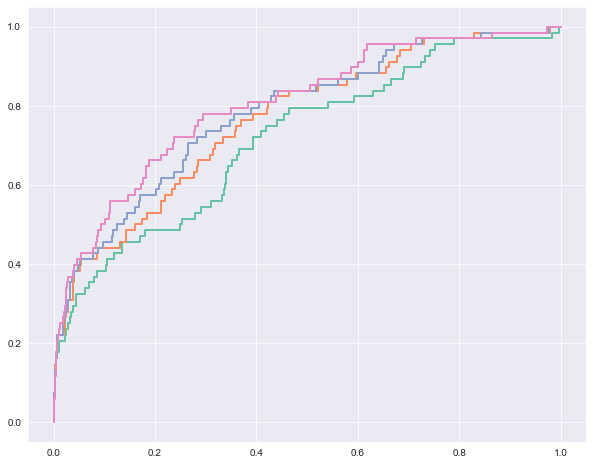

In [8]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
    logreg = LogisticRegression(fit_intercept=False, C=1e20, solver ='lbfgs')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Hopefully this should make sense; after synthetically resampling our data, we no longer need to lean on penalized class weights in order to improve our model tuning. Since *SMOTE* recreated our dataset to have a balanced number of positive and negative cases, aggressive weighting schemas such as 10:1, 100:1 or 1000:1 drastically impact our model performance; the data is effectively no longer class imbalanced, so creating the class weights effectively reintroduces the original problem. Overall, our SMOTE unweighted model appears to be the current top performer. In practice, it is up to you the modeler, to make this and other choices when comparing models. For example, you may also wish to tune other parameters in your model such as how to perform regularization.   

As a review, recall that regularization terms are penalties to a more straightforward error expression between our model and its outputs. The two most common regularizations are the l1 lasso and l2 ridge penalties. These add additional complexity to the loss function. In scikit-learn, these can be specified when initializing your regression object as in: 

```{python}
logreg = LogisticRegression(penalty='l1')
```

The default is to use an 'l2' penalty, so unless you specified otherwise, that's what you've been using.   

In addition to simply specifying how to regularize the model, you can also specify the amount of regularization. This is controlled through the `C` parameter. For example, here is the ROC curve of various regularization values with no corrections for class imbalance:

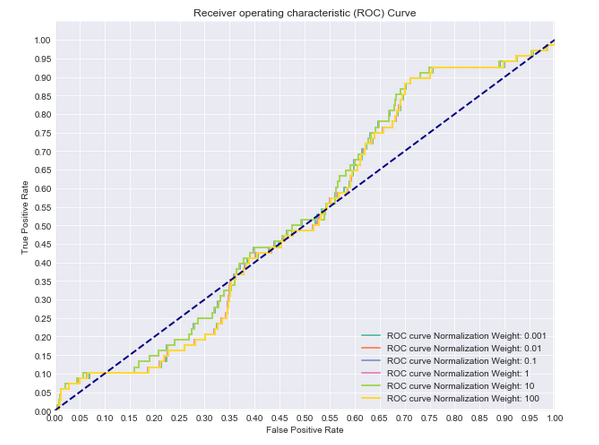

As you can see, all of these models perform poorly regardless of the amount of regularization. 

In this lesson, we investigated various tuning parameters for our model, as well as dealing with class imbalance as a whole. In the upcoming lab, you'll have a chance to try and adjust these parameters yourself in order to optimize a model for predicting credit fraud.

## Predicting Credit Card Fraud

In [9]:
#loading necessary libraries
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Use Pandas to load the compressed CSV file, `'creditcard.csv.gz'`. 

> Note: You need to pass an additional argument (`compression='gzip'`) to read_csv() in order to load compressed CSV files.

In [10]:
# Load a compressed csv file
df = pd.read_csv('creditcard.csv.gz', compression='gzip')  
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Preview the class imbalance

Did you notice that the dataset has 31 columns? The first is a time field followed by columns V1 - V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary `'Class'` flag. This last column, `'Class'`, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is: 

In [13]:
# Count the number of fraudulent/infraudulent purchases
print('Raw counts: \n')
print(df['Class'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['Class'].value_counts(normalize=True))

Raw counts: 

Class
0    284315
1       492
Name: count, dtype: int64
-----------------------------------
Normalized counts: 

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [14]:
#Split dataset
y = df['Class']
X = df.drop(columns=['Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
# Class Imbalance in Training set
print('Class Imbalance in Train Set: \n')
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print('-----------------------------------')
# Class Imbalance Test set
print('Class Imbalance in Test Set: \n')
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Class Imbalance in Train Set: 

Class
0    213233
1       372
Name: count, dtype: int64
Class
0    0.998258
1    0.001742
Name: proportion, dtype: float64
-----------------------------------
Class Imbalance in Test Set: 

Class
0    71082
1      120
Name: count, dtype: int64
Class
0    0.998315
1    0.001685
Name: proportion, dtype: float64


As a baseline, we will train a vanilla logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

AUC: 0.8841412031175263


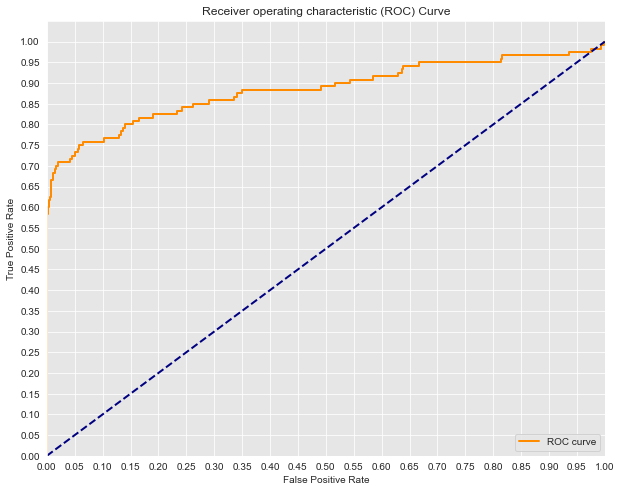

In [20]:
#Base logistic regression model

# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Generating our Predictions
pred = logreg.predict(X_test)

Use scikit-learn's `plot_confusion_matrix` function to plot the confusion matrix of the test set:

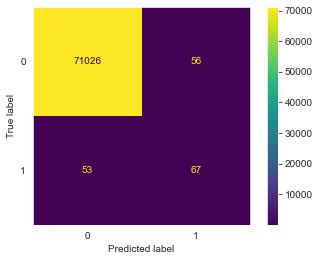

In [23]:
# Plot confusion matrix of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.grid(False) # removes the annoying grid lines from plot
plt.show()

Tuning model using the various techniques proposed to tune your model. Compare your models using AUC and ROC curve.

LogisticRegression(C=0.001, fit_intercept=False, solver='liblinear')
AUC for 0.001: 0.8397641690817178
-------------------------------------------------------
LogisticRegression(C=0.01, fit_intercept=False, solver='liblinear')
AUC for 0.01: 0.8817811354023053
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.8839372133592189
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.8841412031175263
-------------------------------------------------------
LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
AUC for 10: 0.8841608986803972
-------------------------------------------------------
LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
AUC for 100: 0.8841627744482896
-------------------------------------------------------


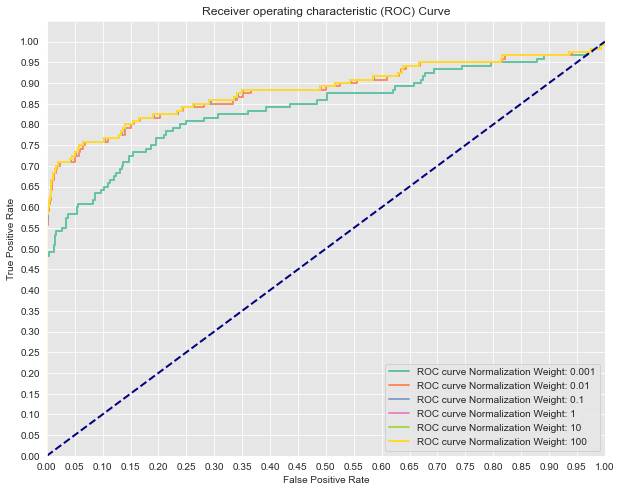

In [24]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### SMOTE

Use the `SMOTE` class from the `imblearn` package in order to improve the model's performance on the minority class.

In [25]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

Class
0    213233
1       372
Name: count, dtype: int64


Class
0    213233
1    213233
Name: count, dtype: int64


Similar to what you did above, build models with this resampled training data:

LogisticRegression(C=0.005, fit_intercept=False, solver='liblinear')
AUC for 0.005: 0.9618295302139312
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.9618506326027217
-------------------------------------------------------
LogisticRegression(C=0.2, fit_intercept=False, solver='liblinear')
AUC for 0.2: 0.9618509843092016
-------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, solver='liblinear')
AUC for 0.5: 0.9624019911276178
-------------------------------------------------------
LogisticRegression(C=0.8, fit_intercept=False, solver='liblinear')
AUC for 0.8: 0.961852391135121
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.9624024600695911
-------------------------------------------------------
LogisticRegression(C=1.25, fit_intercept=False, solver='liblinear')
AUC

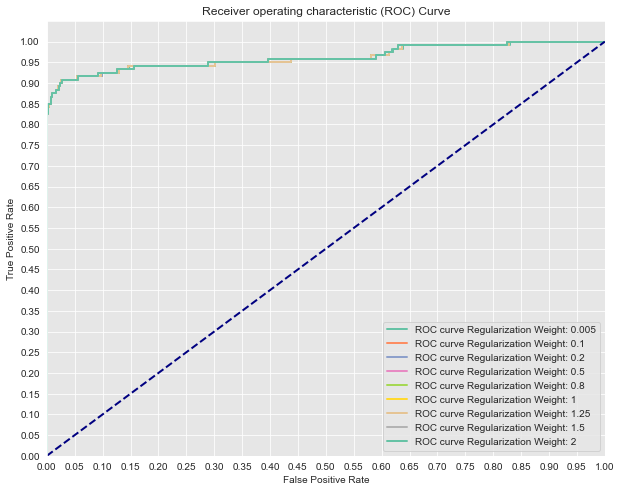

In [26]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Something wrong here? 
Describe what is misleading about the AUC score and ROC curves produced by this code:

Class
0    284315
1       492
Name: count, dtype: int64
---------------------------------
Class
0    284315
1    284315
Name: count, dtype: int64
----------------------------------------------
AUC for 0.005: 0.9910814913671375
----------------------------------------------
AUC for 0.1: 0.9910702164201093
----------------------------------------------
AUC for 0.2: 0.9910698999227285
----------------------------------------------
AUC for 0.3: 0.9910697892773026
----------------------------------------------
AUC for 0.5: 0.9910696988212032
----------------------------------------------
AUC for 0.6: 0.9910696835802413
----------------------------------------------
AUC for 0.7: 0.9910696748711201
----------------------------------------------
AUC for 0.8: 0.9910696624012422


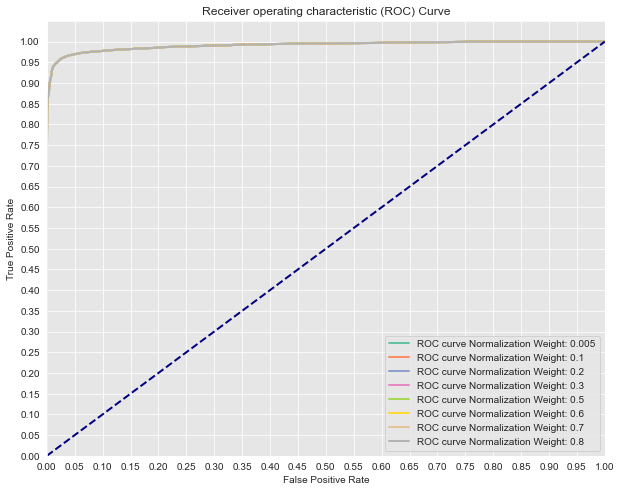

In [27]:
# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_resample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('----------------------------------------------')
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

> This ROC curve is misleading because the test set was also manipulated using SMOTE. This produces results that will not be comparable to future cases as we have synthetically created test cases.

> SMOTE should only be applied to training sets, and then from there, an accurate gauge can be made on the model's performance by using a raw test sample that has not been oversampled or undersampled.

## Summary

In this lab, you got some hands-on practice tuning logistic regression models. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.